In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 25)
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, auc, roc_auc_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
import time
import gc

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [92]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [2]:
def str_encode(data, encoder_dict=None):
    '''
    convert string variables to int, no one-hot-encode
    If used first time, initiate encoder_dict, else user can specify encoder_dict
    '''
    res = data.copy()
    if encoder_dict is None:
        encoder_dict = {}
        for col in data.columns:
            if data[col].dtype == 'object': #if typeof(col) == 'object'
                str_dict = dict(zip(np.unique(data[col]), range(len(np.unique(data[col])))))
                res[col] = data[col].map(str_dict)
                encoder_dict[col] = str_dict
        return res, encoder_dict
    else:
        for col in data.columns:
            if data[col].dtype == 'object':
                str_dict = encoder_dict[col]
                res[col] = data[col].map(str_dict)
        return res

def str_onehotencode(data, encoder_dict=None):
    '''convert string variables to one-hot-encode'''
    res = data.copy()
    encoder_dict = None
    if encoder_dict is None:
        encoder_dict = {}
        for col in data.columns:
            if data[col].dtype == 'object':
                str_dict = dict(zip(np.unique(data[col]), range(len(np.unique(data[col])))))
                for i in list(str_dict.keys()):
                    res[f'{col}_{str_dict[i]}'] = (data[col] == i).astype(int)
                encoder_dict[col] = str_dict
                res = res.drop([col],1)
        return res, encoder_dict
    else:
        for col in data.columns:
            if data[col].dtype == 'object':
                str_dict = encoder_dict[col]
                for i in list(str_dict.keys()):
                    res[f'{col}_{str_dict[i]}'] = (data[col] == i).astype(int)
                res = res.drop([col],1)
        return res
        
df_e, encoder_dict = str_encode(data)
df_e.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


In [3]:
df_ohe, encoder_dict = str_onehotencode(data)
df_ohe.head()

,age,new_user,total_pages_visited,converted,country_0,country_1,country_2,country_3,source_0,source_1,source_2
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [93]:
encoder_dict

{'country': {'China': 0, 'Germany': 1, 'UK': 2, 'US': 3},
 'source': {'Ads': 0, 'Direct': 1, 'Seo': 2}}

## Co-linearity?
    if you need to remove co-linear features

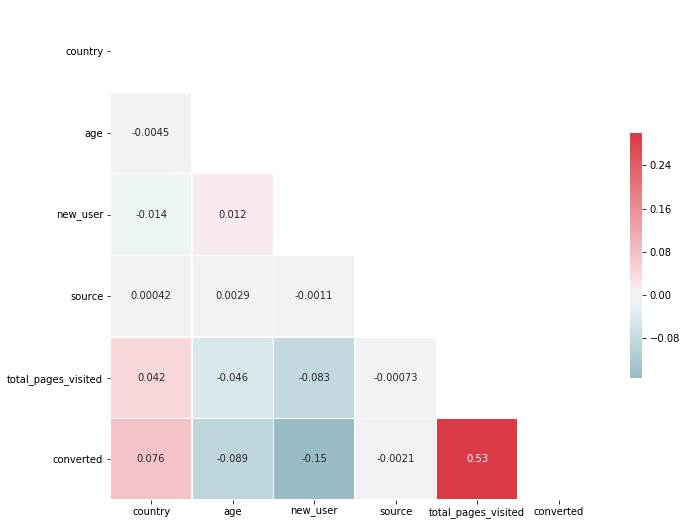

In [4]:
corr = df_e.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Pandas data aggregation
    say you want to know what's the mean/min/max age, proportion of new users, proportion of source, mean/min/max total_pages_visited, mean converted of users from different country

In [139]:
df_e.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


In [152]:
def Range(x):
    return np.max(x) - np.min(x)
def ratio_of_zero(x):
    return len(x[x==0])/len(x)
def ratio_of_one(x):
    return len(x[x==1])/len(x)
def ratio_of_two(x):
    return len(x[x==2])/len(x)
def iqr(x):
    return np.percentile(x,75) - np.percentile(x,25)

agg_dict = {'age': ['mean','min','max',np.std, Range],
            'new_user': ['mean'],
            'source': [ratio_of_zero,ratio_of_one,ratio_of_two],
            'total_pages_visited': ['mean','min','max',np.std, Range,iqr],
            'converted':['mean']
           }

df_agg = df_e.groupby('country').agg(agg_dict)
df_agg.head()

age                           new_user        source  \
              mean min  max       std Range      mean ratio_of_zero   
country                                                               
0        30.672972  17   69  8.283862    52  0.698520      0.281468   
1        30.449985  17  123  8.289022   106  0.677237      0.287990   
2        30.451538  17  111  8.244991    94  0.679835      0.279009   
3        30.566482  17   79  8.272128    62  0.681985      0.280198   

                                  total_pages_visited                          \
        ratio_of_one ratio_of_two                mean min max       std Range   
country                                                                         
0           0.227971     0.490562            4.553523   1  26  2.804987    25   
1           0.219363     0.492647            5.190717   1  27  3.762899    26   
2           0.229742     0.491249            5.082167   1  27  3.630763    26   
3           0.230005     0.489797            4.930160   1  29  3.427085    28   

            converted  
        iqr      mean  
country                
0         4  0.001332  
1         5  0.062500  
2         5  0.052632  
3         5  0.037801

In [153]:
df_agg.columns = ["_".join(x) for x in df_agg.columns.ravel()] 
#df_agg = df_agg.reset_index()
df_agg.head()

,age_mean,age_min,age_max,age_std,age_Range,new_user_mean,source_ratio_of_zero,source_ratio_of_one,source_ratio_of_two,total_pages_visited_mean,total_pages_visited_min,total_pages_visited_max,total_pages_visited_std,total_pages_visited_Range,total_pages_visited_iqr,converted_mean
country,,,,,,,,,,,,,,,,
0,30.672972,17,69,8.283862,52,0.698520,0.281468,0.227971,0.490562,4.553523,1,26,2.804987,25,4,0.001332
1,30.449985,17,123,8.289022,106,0.677237,0.287990,0.219363,0.492647,5.190717,1,27,3.762899,26,5,0.062500
2,30.451538,17,111,8.244991,94,0.679835,0.279009,0.229742,0.491249,5.082167,1,27,3.630763,26,5,0.052632
3,30.566482,17,79,8.272128,62,0.681985,0.280198,0.230005,0.489797,4.930160,1,29,3.427085,28,5,0.037801


## KFold pipeline
    works for all sklearn models!

In [35]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


def KFold_sklearn(df, clf, n_splits=5, target='converted', name='RandomForestClassifier'):
    #print('Number of features = {}'.format(df.shape[1]-1))
    start_time = time.time()
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(len(df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, df[target].round())):    
                
        x_trn, y_trn = df.drop([target],axis=1).iloc[trn_idx], df[target].iloc[trn_idx]
        x_val, y_val = df.drop([target],axis=1).iloc[val_idx], df[target].iloc[val_idx]
        
        clf.fit(x_trn, y_trn)
        preds = clf.predict(x_val)
        oof[val_idx] = preds
        
        ACC = accuracy_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        REC = recall_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        PRE = precision_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        AUC = roc_auc_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        KAP = cohen_kappa_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        F1  = f1_score(df[target].iloc[val_idx], oof[val_idx]).round(3)
        #print(f'fold {fold_}: \naccuracy score: {ACC}   recall: {REC}   precision: {PRE}   AUC: {AUC}    kappa: {KAP}   F1: {F1}')
    
    ACC = accuracy_score(df[target], oof).round(3)
    REC = recall_score(df[target], oof).round(3)
    PRE = precision_score(df[target], oof).round(3)
    AUC = roc_auc_score(df[target], oof).round(3)
    KAP = cohen_kappa_score(df[target], oof).round(3)
    F1  = f1_score(df[target], oof).round(3)
    
    print(f'{ACC}\t\t{REC}\t{PRE}\t\t{AUC}\t{F1}\t{round(time.time() - start_time,0)}\t\t{name}')
    #print('Confusion matrix:')
    #print(confusion_matrix(df[target], oof))
    return oof


In [36]:
clf_list = [
    MLPClassifier(**{'random_state':0}),
    AdaBoostClassifier(**{'n_estimators':100,'random_state':0}),
    RandomForestClassifier(**{'random_state':0, 'n_estimators':100, 'n_jobs':-1, 'max_depth':10}),
    DecisionTreeClassifier(**{'random_state':0, 'max_depth':10}),
    LogisticRegression(**{'random_state':0, 'C':2}),
    QuadraticDiscriminantAnalysis(**{}),
    GaussianNB(**{}),
    KNeighborsClassifier(**{'n_jobs':-1}),
    BaggingClassifier(**{'random_state':0, 'n_jobs':-1}),
    ExtraTreesClassifier(**{'random_state':0, 'n_jobs':-1}),
    SGDClassifier(**{'random_state':0, 'n_jobs':-1}),
    LinearSVC(**{'random_state':0}),
]

name_list = [*map(lambda t:str(t.__class__).split('.')[-1].strip("'>"), clf_list)]
name_list

['MLPClassifier',
 'AdaBoostClassifier',
 'RandomForestClassifier',
 'DecisionTreeClassifier',
 'LogisticRegression',
 'QuadraticDiscriminantAnalysis',
 'GaussianNB',
 'KNeighborsClassifier',
 'BaggingClassifier',
 'ExtraTreesClassifier',
 'SGDClassifier',
 'LinearSVC']

In [37]:
### Scale
scaler = StandardScaler()
df_ohe_scaled = pd.DataFrame(scaler.fit_transform(df_ohe.drop(['converted'],1)))
df_ohe_scaled['converted'] = df_ohe['converted']
df_ohe_scaled.columns = df_ohe.columns
df_ohe_scaled['converted'] = (df_ohe_scaled['converted']).astype(int)

scaler = StandardScaler()
df_e_scaled = pd.DataFrame(scaler.fit_transform(df_e.drop(['converted'],1)))
df_e_scaled['converted'] = df_e['converted']
df_e_scaled.columns = df_e.columns
df_e_scaled['converted'] = (df_e_scaled['converted']).astype(int)


In [38]:
oof_list_ohe = []
print('Accuracy\tRecall\tPrecision\tAUC\tF1\tTime(s)\t\tModel')
for i in range(len(clf_list)):
    oof = KFold_sklearn(df_ohe, clf_list[i], name=name_list[i])
    oof_list_ohe.append(oof)

Accuracy	Recall	Precision	AUC	F1	Time(s)		Model
0.986		0.662	0.87		0.829	0.752	158.0		MLPClassifier
0.986		0.685	0.853		0.841	0.76	42.0		AdaBoostClassifier
0.986		0.683	0.845		0.839	0.756	23.0		RandomForestClassifier
0.986		0.679	0.842		0.837	0.752	4.0		DecisionTreeClassifier
0.986		0.689	0.855		0.842	0.763	5.0		LogisticRegression
0.921		0.806	0.264		0.866	0.398	3.0		QuadraticDiscriminantAnalysis
0.964		0.845	0.471		0.907	0.605	3.0		GaussianNB
0.985		0.669	0.82		0.832	0.737	27.0		KNeighborsClassifier
0.984		0.669	0.81		0.832	0.733	23.0		BaggingClassifier
0.984		0.649	0.828		0.822	0.728	5.0		ExtraTreesClassifier
0.983		0.728	0.741		0.86	0.735	14.0		SGDClassifier
0.984		0.662	0.819		0.829	0.732	128.0		LinearSVC


In [39]:
oof_list_e = []
print('Accuracy\tRecall\tPrecision\tAUC\tF1\tTime(s)\t\tModel')
for i in range(len(clf_list)):
    oof = KFold_sklearn(df_e, clf_list[i], name=name_list[i])
    oof_list_e.append(oof)

Accuracy	Recall	Precision	AUC	F1	Time(s)		Model
0.986		0.701	0.835		0.848	0.762	112.0		MLPClassifier
0.986		0.685	0.853		0.84	0.76	36.0		AdaBoostClassifier
0.986		0.686	0.847		0.841	0.758	21.0		RandomForestClassifier
0.986		0.68	0.842		0.838	0.753	3.0		DecisionTreeClassifier
0.986		0.671	0.849		0.834	0.75	5.0		LogisticRegression
0.983		0.768	0.728		0.879	0.747	3.0		QuadraticDiscriminantAnalysis
0.983		0.768	0.727		0.879	0.747	3.0		GaussianNB
0.985		0.671	0.818		0.833	0.737	20.0		KNeighborsClassifier
0.984		0.67	0.81		0.832	0.733	21.0		BaggingClassifier
0.984		0.65	0.827		0.822	0.728	5.0		ExtraTreesClassifier
0.983		0.665	0.783		0.83	0.719	12.0		SGDClassifier
0.984		0.61	0.845		0.803	0.708	131.0		LinearSVC


In [40]:
oof_list_e_scaled = []
print('Accuracy\tRecall\tPrecision\tAUC\tF1\tTime(s)\t\tModel')
for i in range(len(clf_list)):
    oof = KFold_sklearn(df_e_scaled, clf_list[i], name=name_list[i])
    oof_list_e_scaled.append(oof)

Accuracy	Recall	Precision	AUC	F1	Time(s)		Model
0.986		0.701	0.833		0.848	0.761	56.0		MLPClassifier
0.986		0.685	0.853		0.84	0.76	35.0		AdaBoostClassifier
0.986		0.686	0.847		0.841	0.758	21.0		RandomForestClassifier
0.986		0.68	0.842		0.838	0.752	3.0		DecisionTreeClassifier
0.986		0.671	0.849		0.833	0.749	4.0		LogisticRegression
0.983		0.768	0.728		0.879	0.747	3.0		QuadraticDiscriminantAnalysis
0.983		0.768	0.727		0.879	0.747	3.0		GaussianNB
0.984		0.676	0.807		0.835	0.736	25.0		KNeighborsClassifier
0.984		0.669	0.81		0.832	0.733	21.0		BaggingClassifier
0.984		0.65	0.827		0.823	0.728	5.0		ExtraTreesClassifier
0.985		0.663	0.85		0.83	0.745	4.0		SGDClassifier
0.985		0.65	0.865		0.823	0.742	25.0		LinearSVC


In [26]:
def KFold_lgb(df, param, categorial_features, n_splits=5, target='converted'):

    print('Number of features = {}'.format(df.shape[1]-1))

    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(len(df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, df[target].round())):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df.drop([target],axis=1).iloc[trn_idx], label=df[target].iloc[trn_idx],
                               categorical_feature=categorial_features
                              )
        val_data = lgb.Dataset(df.drop([target],axis=1).iloc[val_idx], label=df[target].iloc[val_idx],
                               categorical_feature=categorial_features
                              )
        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=1000)
        preds = clf.predict(df.drop([target],axis=1).iloc[val_idx], num_iteration=clf.best_iteration)
        oof[val_idx] = preds.round()
        
    ACC = accuracy_score(df[target], oof).round(3)
    REC = recall_score(df[target], oof).round(3)
    PRE = precision_score(df[target], oof).round(3)
    AUC = roc_auc_score(df[target], oof).round(3)
    F1  = f1_score(df[target], oof).round(3)
    
    print(f'Final result: \naccuracy score: {ACC}   recall: {REC}   precision: {PRE}   AUC: {AUC}  F1: {F1}')
    #print('Confusion matrix:')
    #print(confusion_matrix(df[target], oof))
    return oof

param = {'feature_fraction':0.95, 'reg_alpha': 10, 'reg_lambda':10, 
         'objective':'binary', 'metric':'binary', 'boosting':'gbdt',
         'seed':42, 'bagging_seed':42, 'feature_fraction_seed':42,
         'n_jobs':-1
        }



In [27]:
oof_lgb_e = KFold_lgb(df_e, param, ['country','new_user','source'])


Number of features = 5
fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0399257	valid_1's binary_logloss: 0.0419985
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.0399257	valid_1's binary_logloss: 0.0419985
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0404424	valid_1's binary_logloss: 0.0400415
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0404424	valid_1's binary_logloss: 0.0400414
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0402128	valid_1's binary_logloss: 0.0408632
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0402128	valid_1's binary_logloss: 0.0408632
fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.040134	valid_1's binary_logloss: 0.0412131
Early stopping, best iteration i

In [30]:
oof_lgb_e_scaled = KFold_lgb(df_e_scaled, param, ['country','new_user','source'])


Number of features = 5
fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0402937	valid_1's binary_logloss: 0.042195
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0402937	valid_1's binary_logloss: 0.042195
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0407849	valid_1's binary_logloss: 0.0402084
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.040785	valid_1's binary_logloss: 0.0402084
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.040623	valid_1's binary_logloss: 0.0408628
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.040623	valid_1's binary_logloss: 0.0408628
fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0405609	valid_1's binary_logloss: 0.0413371
Early stopping, best iteration is:
[

## Hyperparameter tuning with optuna

In [13]:
import optuna

def objective(trial, num_folds=5, stratified=True, target='converted'):
    
    """
    gbdt is the most popular one
    you usually only need gbdt or goss, dart rarely works and I haven't tried rf before
    """
    
    categorical_features = ['country','new_user','source']
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
        
    oof_preds = np.zeros(df_e.shape[0])
    feats = [f for f in df_e.columns if f !=target]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_e[feats], df_e[target])):
        train_x, train_y = df_e[feats].iloc[train_idx], df_e[target].iloc[train_idx]
        valid_x, valid_y = df_e[feats].iloc[valid_idx], df_e[target].iloc[valid_idx]

        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        param = {'objective': 'binary', 'metric': 'binary', 'verbosity': -1, 'n_jobs': -1, 
                 #'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt','dart','rf']),
                 'boosting_type':'gbdt','seed':42, 'feature_fraction_seed':42,
                 'learning_rate': trial.suggest_uniform('learning_rate', 1e-2, 1e-1),
                 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.9, 1.),
                 'num_leaves': trial.suggest_int('num_leaves', 20, 40),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 30),
                 'max_depth': trial.suggest_int('max_depth', 10,20),
                 'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10),
                 'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
                 'subsample': trial.suggest_uniform('subsample', 0.9, 1.0),
                 'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
                 'min_split_gain': trial.suggest_int('min_split_gain', 0, 10),
                }
        
        if param['boosting_type'] == 'dart':
            param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
            param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

        elif param['boosting_type'] == 'goss':
            param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
            param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])
            
        else:
            param['bagging_freq'] = trial.suggest_int('bagging_freq', 0, 10)
            param['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.9, 1.0)
            param['bagging_seed'] = 42
    
    
        clf = lgb.train(param, lgb_train, 40000, valid_sets=[lgb_train, lgb_test],
                        verbose_eval=10000, early_stopping_rounds=1000)
            
        oof_preds[valid_idx] = clf.predict(df_e.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
        
        del clf, train_x, train_y, valid_x, valid_y, train_idx, valid_idx
        gc.collect()
    
    return (-1) * (f1_score(df_e[target], oof_preds.round()))


In [14]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=20)
print('study.best_params: \t')
print(study.best_params)
print('study.best_value: \t')
print(study.best_value)
print('study.best_trial.user_attrs: \t')
print(study.best_trial.user_attrs)
optuna_lgb = study.trials_dataframe()
optuna_lgb.to_csv("magic.csv")


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0399785	valid_1's binary_logloss: 0.0420321
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0404978	valid_1's binary_logloss: 0.0400385
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0402943	valid_1's binary_logloss: 0.040779
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0402264	valid_1's binary_logloss: 0.0411117
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.040224	valid_1's binary_logloss: 0.0409846


[I 2020-02-08 09:42:21,302] Finished a trial resulted in value: -0.7633596027205009. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0403146	valid_1's binary_logloss: 0.0421423
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0408302	valid_1's binary_logloss: 0.0401736
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.0406347	valid_1's binary_logloss: 0.0408559
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0405446	valid_1's binary_logloss: 0.0413067
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0405792	valid_1's binary_logloss: 0.0410699


[I 2020-02-08 09:43:15,940] Finished a trial resulted in value: -0.7621414294203446. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0402852	valid_1's binary_logloss: 0.0422726
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0407948	valid_1's binary_logloss: 0.0400613
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0405983	valid_1's binary_logloss: 0.040857
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0405167	valid_1's binary_logloss: 0.0412426
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0405408	valid_1's binary_logloss: 0.0410362


[I 2020-02-08 09:44:00,775] Finished a trial resulted in value: -0.7622804647392597. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0406525	valid_1's binary_logloss: 0.0424194
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0411096	valid_1's binary_logloss: 0.0401831
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0409646	valid_1's binary_logloss: 0.041118
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.040894	valid_1's binary_logloss: 0.0416256
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0408109	valid_1's binary_logloss: 0.0412516


[I 2020-02-08 09:44:40,037] Finished a trial resulted in value: -0.7607991360691145. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0403791	valid_1's binary_logloss: 0.0422178
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0408438	valid_1's binary_logloss: 0.0401916
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0406833	valid_1's binary_logloss: 0.0408937
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0405958	valid_1's binary_logloss: 0.0412741
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.0406178	valid_1's binary_logloss: 0.041086


[I 2020-02-08 09:45:18,304] Finished a trial resulted in value: -0.7628622117090479. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0407025	valid_1's binary_logloss: 0.0424712
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0411478	valid_1's binary_logloss: 0.0402774
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.0409925	valid_1's binary_logloss: 0.0410581
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0408623	valid_1's binary_logloss: 0.0414658
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0409158	valid_1's binary_logloss: 0.0411805


[I 2020-02-08 09:45:55,146] Finished a trial resulted in value: -0.7620020429009193. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.039882	valid_1's binary_logloss: 0.0420411
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0404035	valid_1's binary_logloss: 0.0399737
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0401691	valid_1's binary_logloss: 0.0407264
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0401089	valid_1's binary_logloss: 0.0410677
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0401544	valid_1's binary_logloss: 0.0409527


[I 2020-02-08 09:46:48,702] Finished a trial resulted in value: -0.7632699250956513. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.040462	valid_1's binary_logloss: 0.0422297
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0409594	valid_1's binary_logloss: 0.0402165
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0407609	valid_1's binary_logloss: 0.0409406
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0406337	valid_1's binary_logloss: 0.0412349
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0407014	valid_1's binary_logloss: 0.0411638


[I 2020-02-08 09:47:27,649] Finished a trial resulted in value: -0.7629665535627727. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0403568	valid_1's binary_logloss: 0.042179
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0408717	valid_1's binary_logloss: 0.0400519
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0406758	valid_1's binary_logloss: 0.0408621
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0405745	valid_1's binary_logloss: 0.0412652
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.040612	valid_1's binary_logloss: 0.0410358


[I 2020-02-08 09:48:25,170] Finished a trial resulted in value: -0.7626295336787564. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0402829	valid_1's binary_logloss: 0.0421136
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0408149	valid_1's binary_logloss: 0.0400822
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0405704	valid_1's binary_logloss: 0.0408099
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0404948	valid_1's binary_logloss: 0.0412262
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0405162	valid_1's binary_logloss: 0.0409578


[I 2020-02-08 09:49:13,838] Finished a trial resulted in value: -0.7629366106080206. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.0397462	valid_1's binary_logloss: 0.0420923
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.0403187	valid_1's binary_logloss: 0.0399554
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[753]	training's binary_logloss: 0.0400793	valid_1's binary_logloss: 0.0407792
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.0400038	valid_1's binary_logloss: 0.0411474
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.0400945	valid_1's binary_logloss: 0.0409446


[I 2020-02-08 09:52:20,101] Finished a trial resulted in value: -0.7631024990554325. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0404481	valid_1's binary_logloss: 0.0423931
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0409397	valid_1's binary_logloss: 0.0400779
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0407509	valid_1's binary_logloss: 0.0408954
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0406456	valid_1's binary_logloss: 0.0412914
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0406916	valid_1's binary_logloss: 0.0410522


[I 2020-02-08 09:53:10,760] Finished a trial resulted in value: -0.7629901696013828. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0400535	valid_1's binary_logloss: 0.0420489
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0405556	valid_1's binary_logloss: 0.039966
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.040357	valid_1's binary_logloss: 0.0407238
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0402844	valid_1's binary_logloss: 0.0411242
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0403129	valid_1's binary_logloss: 0.0409653


[I 2020-02-08 09:53:53,233] Finished a trial resulted in value: -0.7630656383150854. Current best value is -0.7633596027205009 with parameters: {'learning_rate': 0.08130918703579237, 'feature_fraction': 0.9104236852257412, 'num_leaves': 28, 'min_data_in_leaf': 11, 'max_depth': 11, 'reg_alpha': 2.354741171111124, 'reg_lambda': 7.943330066914159, 'subsample': 0.993096184336284, 'min_child_weight': 2, 'min_split_gain': 1, 'bagging_freq': 8, 'bagging_fraction': 0.9725584934631921}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.040316	valid_1's binary_logloss: 0.0421349
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0408449	valid_1's binary_logloss: 0.0400573
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0406579	valid_1's binary_logloss: 0.0408502
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0405414	valid_1's binary_logloss: 0.0411754
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0405774	valid_1's binary_logloss: 0.0411005


[I 2020-02-08 09:54:29,656] Finished a trial resulted in value: -0.7651409583020687. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0406737	valid_1's binary_logloss: 0.0424629
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0411948	valid_1's binary_logloss: 0.0402267
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0409476	valid_1's binary_logloss: 0.0410055
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0408678	valid_1's binary_logloss: 0.0414406
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.040932	valid_1's binary_logloss: 0.0412004


[I 2020-02-08 09:55:18,729] Finished a trial resulted in value: -0.7635207929325577. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0404424	valid_1's binary_logloss: 0.042275
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0409159	valid_1's binary_logloss: 0.0400903
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0407343	valid_1's binary_logloss: 0.0409122
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0406493	valid_1's binary_logloss: 0.0412504
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0406973	valid_1's binary_logloss: 0.0410569


[I 2020-02-08 09:56:02,526] Finished a trial resulted in value: -0.7638066530304661. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0405905	valid_1's binary_logloss: 0.0423781
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0411347	valid_1's binary_logloss: 0.0402666
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0409179	valid_1's binary_logloss: 0.041042
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.040791	valid_1's binary_logloss: 0.0413599
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0408816	valid_1's binary_logloss: 0.0411618


[I 2020-02-08 09:56:51,750] Finished a trial resulted in value: -0.762854371025116. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0404155	valid_1's binary_logloss: 0.0422704
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0409346	valid_1's binary_logloss: 0.0401774
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0407117	valid_1's binary_logloss: 0.0408657
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0406353	valid_1's binary_logloss: 0.0413032
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.040668	valid_1's binary_logloss: 0.0410457


[I 2020-02-08 09:57:35,254] Finished a trial resulted in value: -0.7624082865774707. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0404133	valid_1's binary_logloss: 0.0421707
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0408935	valid_1's binary_logloss: 0.0401465
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0407399	valid_1's binary_logloss: 0.0409301
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0406386	valid_1's binary_logloss: 0.0412529
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0406533	valid_1's binary_logloss: 0.0410931


[I 2020-02-08 09:58:19,277] Finished a trial resulted in value: -0.7631763122476447. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0398179	valid_1's binary_logloss: 0.0420492
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0402654	valid_1's binary_logloss: 0.0400472
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0402288	valid_1's binary_logloss: 0.0408383
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0401049	valid_1's binary_logloss: 0.041164
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0402185	valid_1's binary_logloss: 0.0410144


[I 2020-02-08 09:59:48,709] Finished a trial resulted in value: -0.7621157274839268. Current best value is -0.7651409583020687 with parameters: {'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}.


study.best_params: 	
{'learning_rate': 0.07755148872608791, 'feature_fraction': 0.9535984461921252, 'num_leaves': 24, 'min_data_in_leaf': 13, 'max_depth': 17, 'reg_alpha': 6.742189622082368, 'reg_lambda': 9.800193440118033, 'subsample': 0.9987429090566036, 'min_child_weight': 1, 'min_split_gain': 2, 'bagging_freq': 9, 'bagging_fraction': 0.9227591042454988}
study.best_value: 	
-0.7651409583020687
study.best_trial.user_attrs: 	
{}
CPU times: user 1h 23min 42s, sys: 7min 45s, total: 1h 31min 28s
Wall time: 18min 8s


In [31]:
best_params = {**{'objective': 'binary', 'metric': 'binary', 'verbosity': -1, 'n_jobs': -1,
                'boosting_type':'gbdt', 'seed':42, 'feature_fraction_seed':42, 'bagging_seed':42},
               **study.best_params}

oof_lgb_best = KFold_lgb(df_e, best_params, ['country','new_user','source'])


Number of features = 5
fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0403146	valid_1's binary_logloss: 0.0421362
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.040316	valid_1's binary_logloss: 0.0421349
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0408449	valid_1's binary_logloss: 0.0400573
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0408449	valid_1's binary_logloss: 0.0400573
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0406579	valid_1's binary_logloss: 0.0408502
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0406579	valid_1's binary_logloss: 0.0408502
fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0405376	valid_1's binary_logloss: 0.0411765
Early stopping, best iteration i

In [77]:
best_params_1 = {**{'objective': 'binary', 'metric': 'binary', 'verbosity': -1, 'n_jobs': -1,
                 'boosting_type':'gbdt', 'seed':42, 'feature_fraction_seed':42, 'bagging_seed':42},
                 **study.trials_dataframe().sort_values(by='value')['params'].iloc[1,:].to_dict()}


for key in ['max_depth','min_child_weight','min_data_in_leaf','min_split_gain','num_leaves','bagging_freq']:
    best_params_1[key] = int(best_params_1[key])


oof_lgb_best_1 = KFold_lgb(df_e, best_params_1, ['country','new_user','source'])


Number of features = 5
fold 0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0404424	valid_1's binary_logloss: 0.042275
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0404424	valid_1's binary_logloss: 0.042275
fold 1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0409146	valid_1's binary_logloss: 0.0400903
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0409159	valid_1's binary_logloss: 0.0400903
fold 2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0407343	valid_1's binary_logloss: 0.0409122
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0407343	valid_1's binary_logloss: 0.0409122
fold 3
Training until validation scores don't improve for 1000 rounds.
[1000]	training's binary_logloss: 0.0406493	valid_1's binary_logloss: 0.0412504
Early stopping, best iteration is

## Stacking models sometimes give better results!

In [83]:
f1_score(df_e['converted'], np.max([oof_lgb_best,oof_lgb_best_1],0))

0.766606248000853

In [91]:
f1_score(df_e['converted'], np.max([oof_lgb_best,oof_lgb_best_1, *oof_list_e[:2]],0))

0.7678646050982031

In [123]:
f1_score(df_e['converted'], np.max([oof_lgb_best,oof_lgb_best_1, *oof_list_e[:2],*oof_list_e_scaled[:2]],0))

0.767915436032955

#### The best stack score that I can get

In [130]:
f1_score(df_e['converted'], np.max([oof_lgb_best,oof_lgb_best_1, *oof_list_e[:2], *oof_list_e_scaled[:2],
                                    *[oof_list_ohe[1]], *[oof_list_ohe[4]],],0))


0.7680033157185785

## The KFold method to do model stacking
    It works better for regression problems, not this time
    The reason why np.max works better for stacking is because we have unbalanced dataset and this is a classification problem
    

In [132]:
oof_features = np.column_stack([oof_lgb_best,oof_lgb_best_1, *oof_list_e[:2], *oof_list_e_scaled[:2],
                                    *[oof_list_ohe[1]], *[oof_list_ohe[4]]])

In [101]:
from sklearn.linear_model import LinearRegression, Ridge

In [133]:
def KFold_stacking(oof_features, target, reg, n_splits=5):
    # choose a different random_state!
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
    stacked_oof = np.zeros(len(target))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(oof_features, target)):    
        
        x_trn, y_trn = oof_features[trn_idx,:], target[trn_idx]
        x_val, y_val = oof_features[val_idx,:], target[val_idx]
                
        reg.fit(x_trn, y_trn)
        
        stacked_preds = reg.predict(x_val)
        stacked_oof[val_idx] = stacked_preds.round()
          
    ACC = accuracy_score(target, stacked_oof).round(3)
    REC = recall_score(target, stacked_oof).round(3)
    PRE = precision_score(target, stacked_oof).round(3)
    AUC = roc_auc_score(target, stacked_oof).round(3)
    KAP = cohen_kappa_score(target, stacked_oof).round(3)
    F1  = f1_score(target, stacked_oof).round(7)
    
    print(f'{ACC}\t\t{REC}\t{PRE}\t\t{AUC}\t{F1}')
    return oof

In [138]:
print('Accuracy\tRecall\tPrecision\tAUC\tF1')
_ = KFold_stacking(oof_features, df_e['converted'], LinearRegression())
_ = KFold_stacking(oof_features[:,:6], df_e['converted'], LinearRegression())
_ = KFold_stacking(oof_features[:,:5], df_e['converted'], LinearRegression())
_ = KFold_stacking(oof_features[:,:4], df_e['converted'], LinearRegression())
_ = KFold_stacking(oof_features[:,:3], df_e['converted'], LinearRegression())
_ = KFold_stacking(oof_features[:,:2], df_e['converted'], LinearRegression())


Accuracy	Recall	Precision	AUC	F1
0.986		0.693	0.848		0.845	0.7630812
0.986		0.694	0.849		0.845	0.7633382
0.986		0.694	0.849		0.845	0.7633382
0.986		0.693	0.849		0.844	0.7628454
0.986		0.7	0.845		0.848	0.7658001
0.986		0.69	0.851		0.843	0.7623119
